In [1]:
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import TensorDataset,DataLoader

import os

import umap
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.decomposition import PCA

from src.models import VAE
from src.training import Trainer

import pandas as pd
import seaborn as sns

from src.visualization import *

In [2]:
data_path = '/stor/huakui/research/VB/ghx/joint-vae/datasets/Adult-heart/HS0244'
train = torch.load(os.path.join(data_path,'train_dataset.pt'))
val = torch.load(os.path.join(data_path,'val_dataset.pt'))
group_indexes = np.load(os.path.join(data_path,'disc_labels_mapping.npy'), allow_pickle = True).item()
group_indexes_reverse = dict()
for group in group_indexes:
    group_indexes_reverse[group] = {value:key for key,value in group_indexes[group].items()}
ln_file = open(os.path.join(data_path, 'label_names.txt'),'r')
label_names = ln_file.read().splitlines()
ln_file.close()

In [3]:
label_name_cont = [idx for idx,name in enumerate(label_names) if name not in group_indexes]
label_name_disc = [idx for idx,name in enumerate(label_names) if name in group_indexes]
# cont: 2 diffused latent, 2 kl latent, each label has a latent to supervise
# disc: 1 clustering latent, 1 kl latent, each label has a latent to supervise
diffuse_cont_dims = [0,1]
KL_cont_dims = [2,3,4,5,6,7]
unsupervised_cont_num = len(diffuse_cont_dims + KL_cont_dims)
cluster_disc_dims = [0,1]
KL_disc_dims = [1]
unsupervised_disc_num = len(cluster_disc_dims + KL_disc_dims)
n_cluster = 5
latent_spec = {'cont': len(label_name_cont) + unsupervised_cont_num, 
               'disc': unsupervised_disc_num*[n_cluster] + [len(i) for i in group_indexes.values()]}


cont_supervise_dict = {idx+len(diffuse_cont_dims)+len(KL_cont_dims):cont_dim for idx,cont_dim in enumerate(label_name_cont)}
disc_supervise_dict = {idx+len(cluster_disc_dims)+len(KL_disc_dims):disc_dim for idx,disc_dim in enumerate(label_name_disc)}
latent_name_cont = [str(i)+'_Diffuse' for i in diffuse_cont_dims] + \
                   [str(i)+'_KL_Cont' for i in KL_cont_dims] +\
                   [str(i)+'_'+label_names[cont_supervise_dict[i]] for i in cont_supervise_dict]
latent_name_disc = [str(i)+'_Cluster' for i in cluster_disc_dims] + \
                   [str(i)+'_KL_Disc' for i in KL_disc_dims] +\
                   [str(i)+'_'+label_names[disc_supervise_dict[i]] for i in disc_supervise_dict]

In [3]:
savePath = '/stor/huakui/research/VB/ghx/joint-vae/results/Adult-heart'
if not os.path.exists(savePath):
    os.makedirs(savePath)
save_figs = False

In [4]:
model = torch.load(os.path.join(savePath, 'model.pth'))

In [5]:
latent_dist_list = {'cont':[], 'disc':[]}
for data in DataLoader(val,batch_size=1024,shuffle=False):
    x = data[0].view(data[0].size(0),-1).cuda()
    with torch.no_grad():
        latent_sample,latent_dist = model(x)
    latent_dist_list['cont'].append(latent_dist['cont'])
    latent_dist_list['disc'].append(latent_dist['disc'])

In [8]:
latent_spec = {'cont': 10, 'disc': [5, 5, 5, 2, 6, 12, 9, 25]}

In [9]:
latent_dist_cont = [torch.cat([x[0] for x in latent_dist_list['cont']], dim=0),
                    torch.cat([x[1] for x in latent_dist_list['cont']], dim=0)]

latent_dist_disc = [torch.cat([x[i] for x in latent_dist_list['disc']], dim=0) for i in range(len(latent_spec['disc']))]
latent_dist = {'cont':latent_dist_cont, 'disc':latent_dist_disc}

In [7]:
for data in DataLoader(val,batch_size=len(train),shuffle=False):
    break

In [ ]:
fig = draw_loss_curves(trainer.losses)
if save_figs:
    fig.savefig(os.path.join(savePath, 'img', 'fig1_lossCurves.png'))
fig.show()

In [11]:
labels_disc = pd.DataFrame()
labels_disc['AR1(label)'] = data[1][:,0].int()
labels_disc['AR1(infer)'] = np.array(torch.argmax(latent_dist['disc'][3].detach().cpu(),dim = 1))
labels_disc['AR2(label)'] = data[1][:,1].int()
labels_disc['AR2(infer)'] = np.array(torch.argmax(latent_dist['disc'][4].detach().cpu(),dim = 1))
labels_disc['AR3(label)'] = data[1][:,2].int()
labels_disc['AR3(infer)'] = np.array(torch.argmax(latent_dist['disc'][5].detach().cpu(),dim = 1))
labels_disc['cellType(label)'] = data[1][:,3].int()
labels_disc['cellType(infer)'] = np.array(torch.argmax(latent_dist['disc'][6].detach().cpu(),dim = 1))

In [25]:
# discrete labels
# each disc label dim is with its supervising latent
labels_disc = pd.DataFrame()
for latent in disc_supervise_dict:
    label_name = label_names[disc_supervise_dict[latent]]
    group_index = group_indexes_reverse[label_name]
    label_pos = [idx for idx,name in enumerate(label_names) if name==label_name][0]
    label = data[1][:,label_pos].int()
    labels_disc[label_name + ' (Label)'] = [group_index[int(i)] for i in label]
    label_hat = torch.argmax(latent_dist['disc'][latent].detach().cpu(),dim = 1)
    labels_disc[label_name + ' (Infer)'] = np.array(label_hat)
# disc latent that under clustering constrain (and also KL)
# cluster_disc_dims = [0]
for idx, latent in enumerate(cluster_disc_dims):
    label_hat = torch.argmax(latent_dist['disc'][latent].detach().cpu(),dim = 1)
    labels_disc['Cluster_Dim_'+str(idx)] = np.array(label_hat)
# disc latent that only under KL constrain
# KL_disc_dims = [i for i in range(len(latent_spec['disc'])) if i not in cluster_disc_dims and i not in disc_supervise_dict]
for idx, latent in enumerate(KL_disc_dims):
    label_hat = torch.argmax(latent_dist['disc'][latent].detach().cpu(),dim = 1)
    labels_disc['KL_Dim_'+str(idx)] = np.array(label_hat)

In [26]:
# continuous labels
# each cont label dim is with its supervising latent
labels_cont = pd.DataFrame()
for latent in cont_supervise_dict:
    label_name = label_names[cont_supervise_dict[latent]]
    label_pos = [idx for idx,name in enumerate(label_names) if name==label_name][0]
    labels_cont[label_name+' (Label)'] = np.array(data[1][:,label_pos])
    label_hat = latent_dist['cont'][0][:,latent].detach().cpu()
    labels_cont[label_name + ' (Infer)'] = np.array(label_hat)
# cont latent that under diffusion constrain
# diffusion_cont_dims = [0,1]
for idx, latent in enumerate(diffuse_cont_dims):
    label_hat = latent_dist['cont'][0][:,latent].detach().cpu()
    labels_cont['Diffuse_Dim_'+str(idx)] = np.array(label_hat)
# cont latent that only under KL constrain
# KL_cont_dims = [i for i in range(latent_spec['cont']) if i not in diffuse_cont_dims and i not in cont_supervise_dict]
for idx, latent in enumerate(KL_cont_dims):
    label_hat = latent_dist['cont'][0][:,latent].detach().cpu()
    labels_cont['KL_Dim_'+str(idx)] = np.array(label_hat)

In [12]:
pc_file = os.path.join(savePath, 'pca.npy')
if False:#os.path.isfile(pc_file):
    pcs = np.load(pc_file)
else:
    pca = PCA(n_components=50)
    pca.fit(data[0].detach().cpu())
    pcs = pca.transform(data[0].detach().cpu())
    np.save(file = pc_file, 
             arr = pcs)

umap_file = os.path.join(savePath, 'umap.npy')
if False:#os.path.isfile(umap_file):
    u = np.load(umap_file)
else:
    u  = umap.UMAP().fit_transform(pcs)
    np.save(file = umap_file, 
            arr = u)

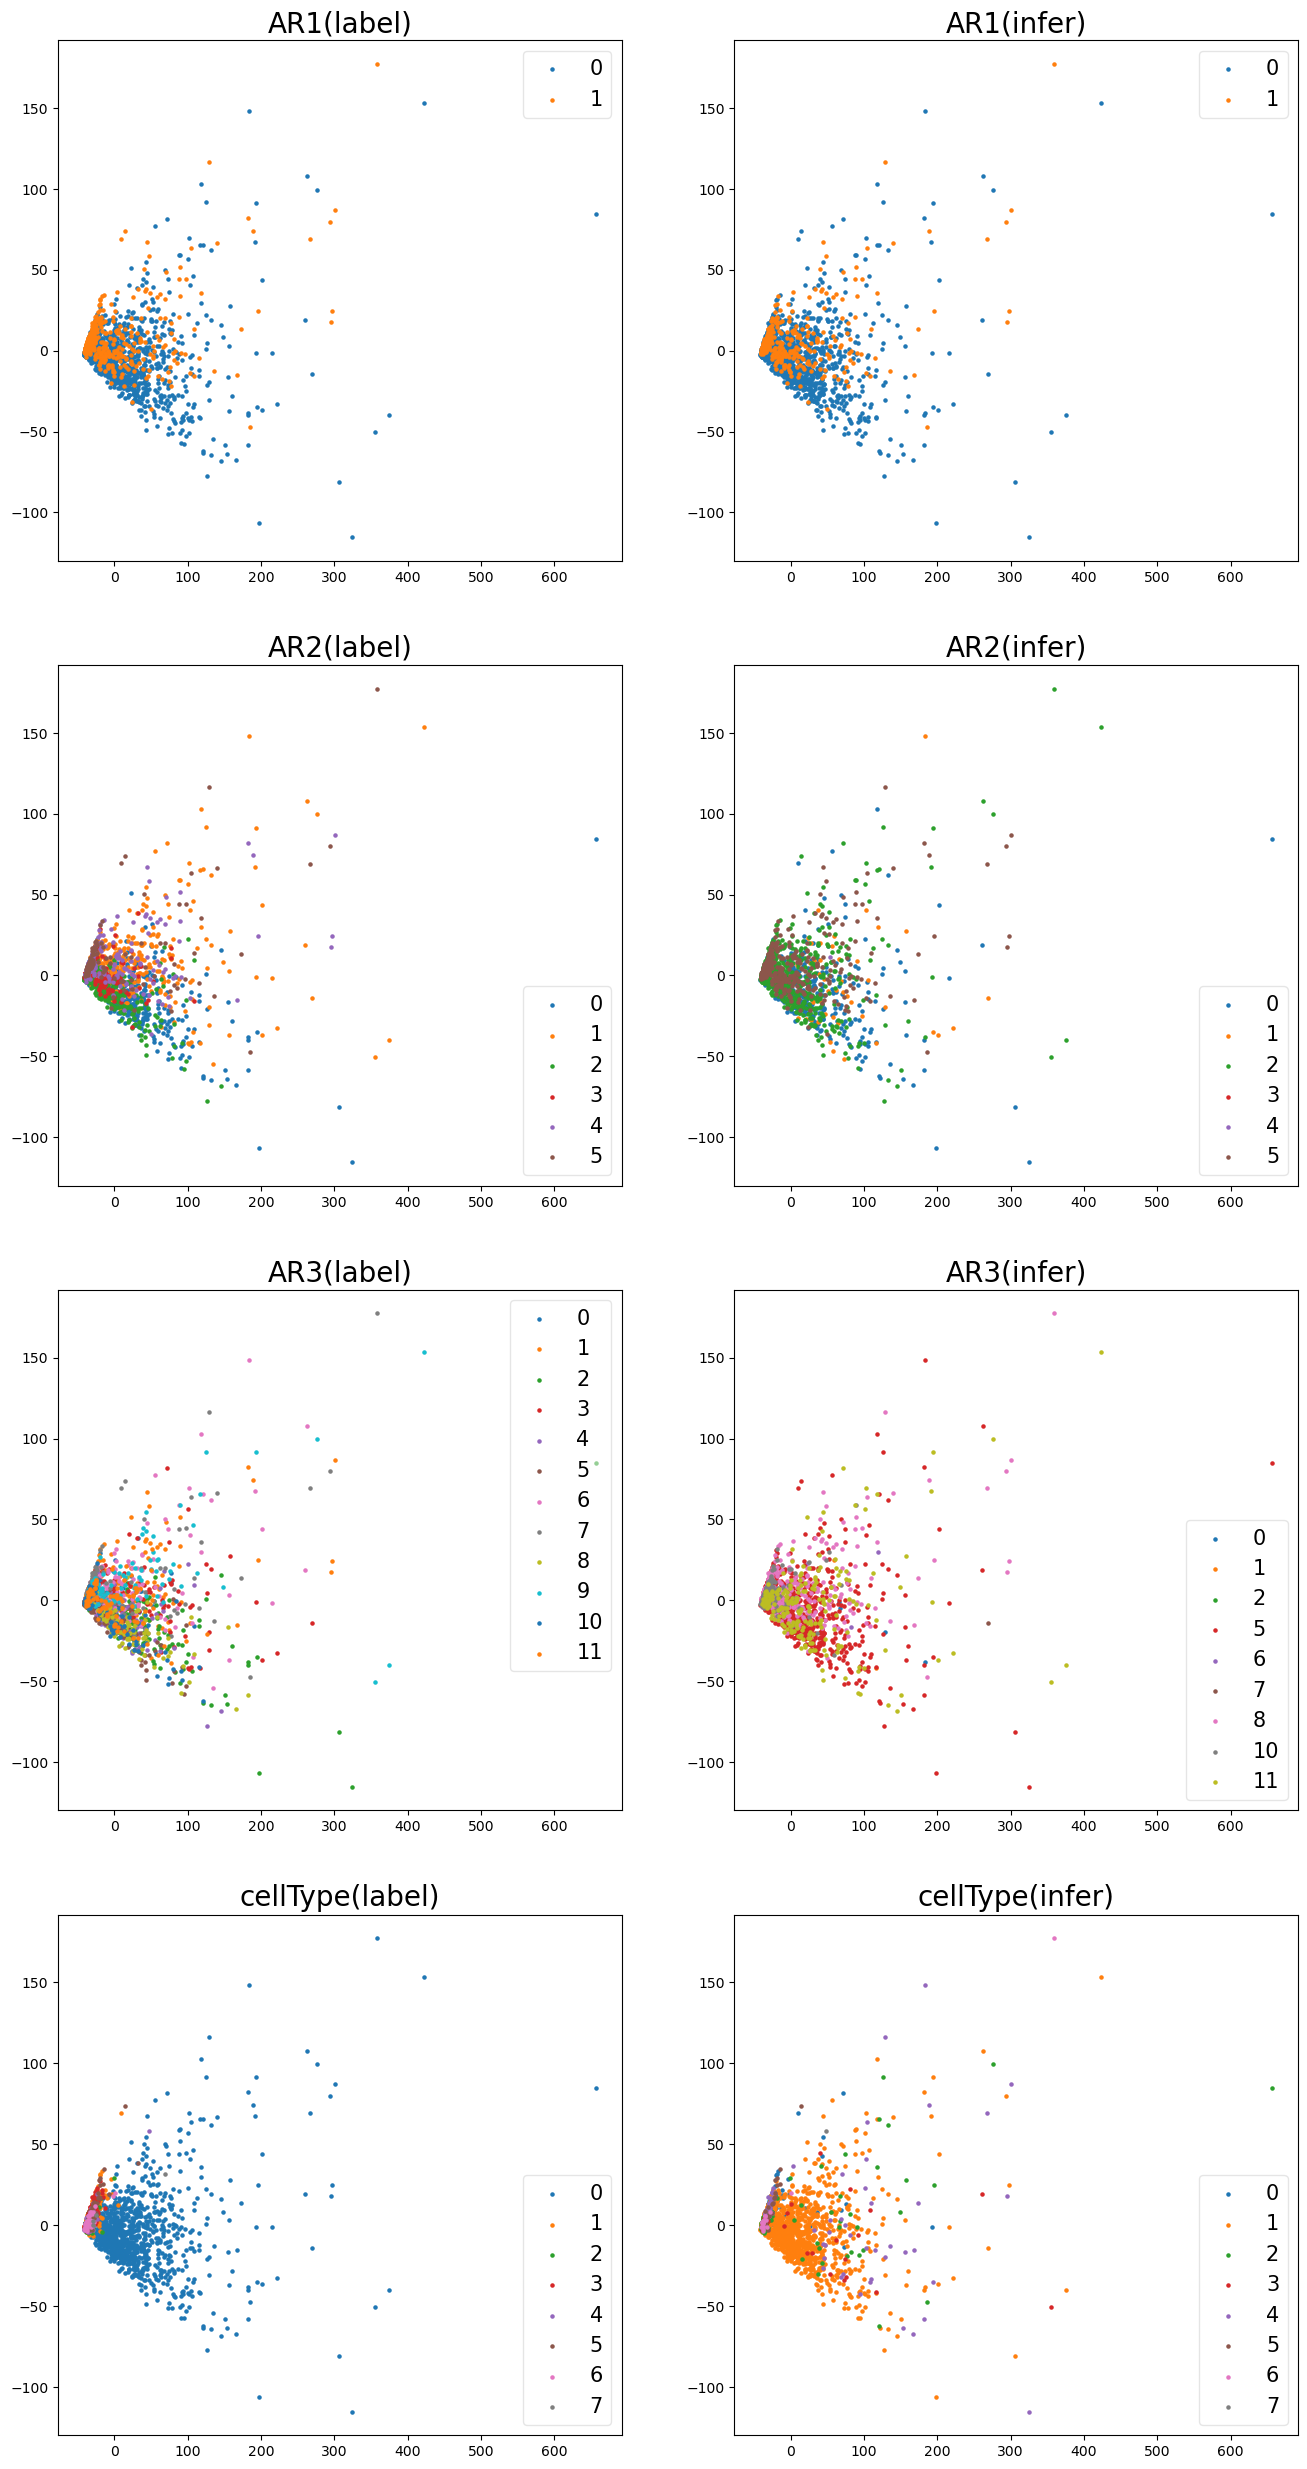

In [13]:
fig = draw_scatter_with_discrete_labels(pcs, labels_disc)
fig.show()

In [15]:
for l in ['AR1','AR2','AR3','cellType']:
    tempLabel = labels_disc[l+('(label)')]
    tempInfer = labels_disc[l+('(infer)')]
    ari = sklearn.metrics.adjusted_rand_score(tempLabel,tempInfer)
    print(l, ari)

AR1 0.6376676113432348
AR2 0.15015995041433555
AR3 0.1160921053925722
cellType 0.28405087128378836


In [18]:
ARI_dict = {}
for ct in np.unique(labels_disc['cellType(label)']):
    tempLoc = [l==ct for l in labels_disc['cellType(label)']]
    tempDF = labels_disc.iloc[tempLoc,:]
    ARI_dict[ct] = {}
    for ar in ['AR1','AR2','AR3']:
        tempLabel = tempDF[ar+'(label)']
        tempInfer = tempDF[ar+'(infer)']
        tempARI = sklearn.metrics.adjusted_rand_score(tempLabel,tempInfer)
        ARI_dict[ct][ar] = tempARI
pd.DataFrame(ARI_dict)

0         1         2         3         4         5         6    7
AR1  0.949554  0.359243  0.397741  0.429172  0.553711  0.267289  0.228571  1.0
AR2  0.192081  0.138522  0.106225  0.080685  0.140582  0.122607  0.089226  1.0
AR3  0.121457  0.200460  0.073246  0.052769  0.089892  0.077454  0.203448  0.0

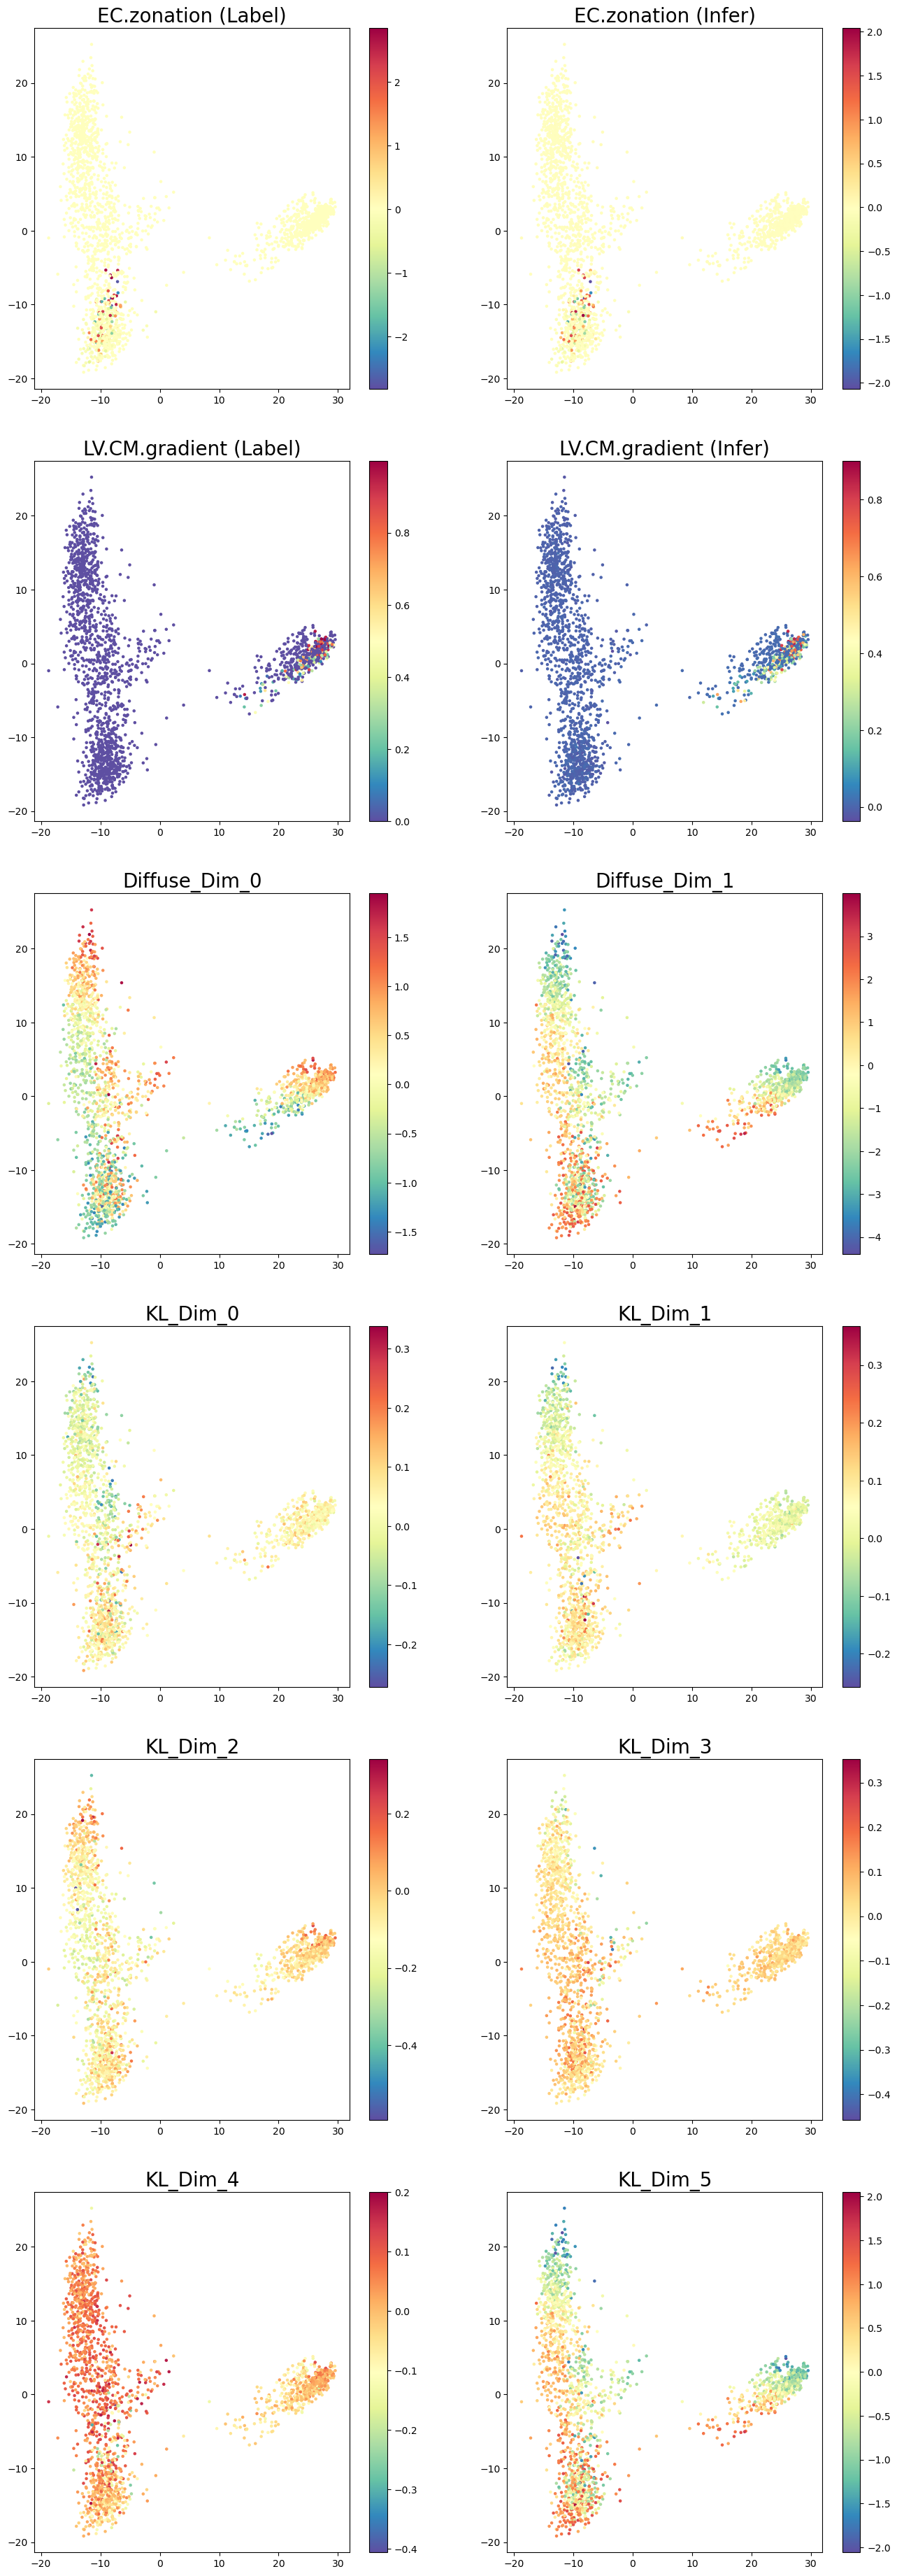

In [29]:
fig = draw_scatter_with_continuous_labels(pcs, labels_cont)
fig.show()

In [49]:
ARI_dict = {}
for ct in np.unique(labels_disc['cellType (Label)']):
    tempLoc = [l==ct for l in labels_disc['cellType (Label)']]
    tempDF = labels_disc.iloc[tempLoc,:]
    ARI_dict[ct] = {}
    for ar in ['AR1','AR2','AR3','subType']:
        tempLabel = tempDF[ar+' (Label)']
        tempInfer = tempDF[ar+' (Infer)']
        tempARI = sklearn.metrics.adjusted_rand_score(tempLabel,tempInfer)
        ARI_dict[ct][ar] = tempARI
pd.DataFrame(ARI_dict)

Adipo        CM        EC        FB     Macro    Neuron      Peri  \
AR1      0.000000  0.983653  0.713622  0.848959  0.679438  0.379884  0.571188   
AR2      0.000000  0.594657  0.277115  0.277495  0.172876  0.125825  0.247707   
AR3      0.004415  0.393750  0.243820  0.158945  0.100832  0.201592  0.126134   
subType  0.000000  0.973409  0.700612  0.867890  0.349870  0.000000  0.423269   

              SMC         T  
AR1      0.436661  0.534612  
AR2      0.099942  0.176027  
AR3      0.060032  0.089624  
subType  0.676543 -0.049405

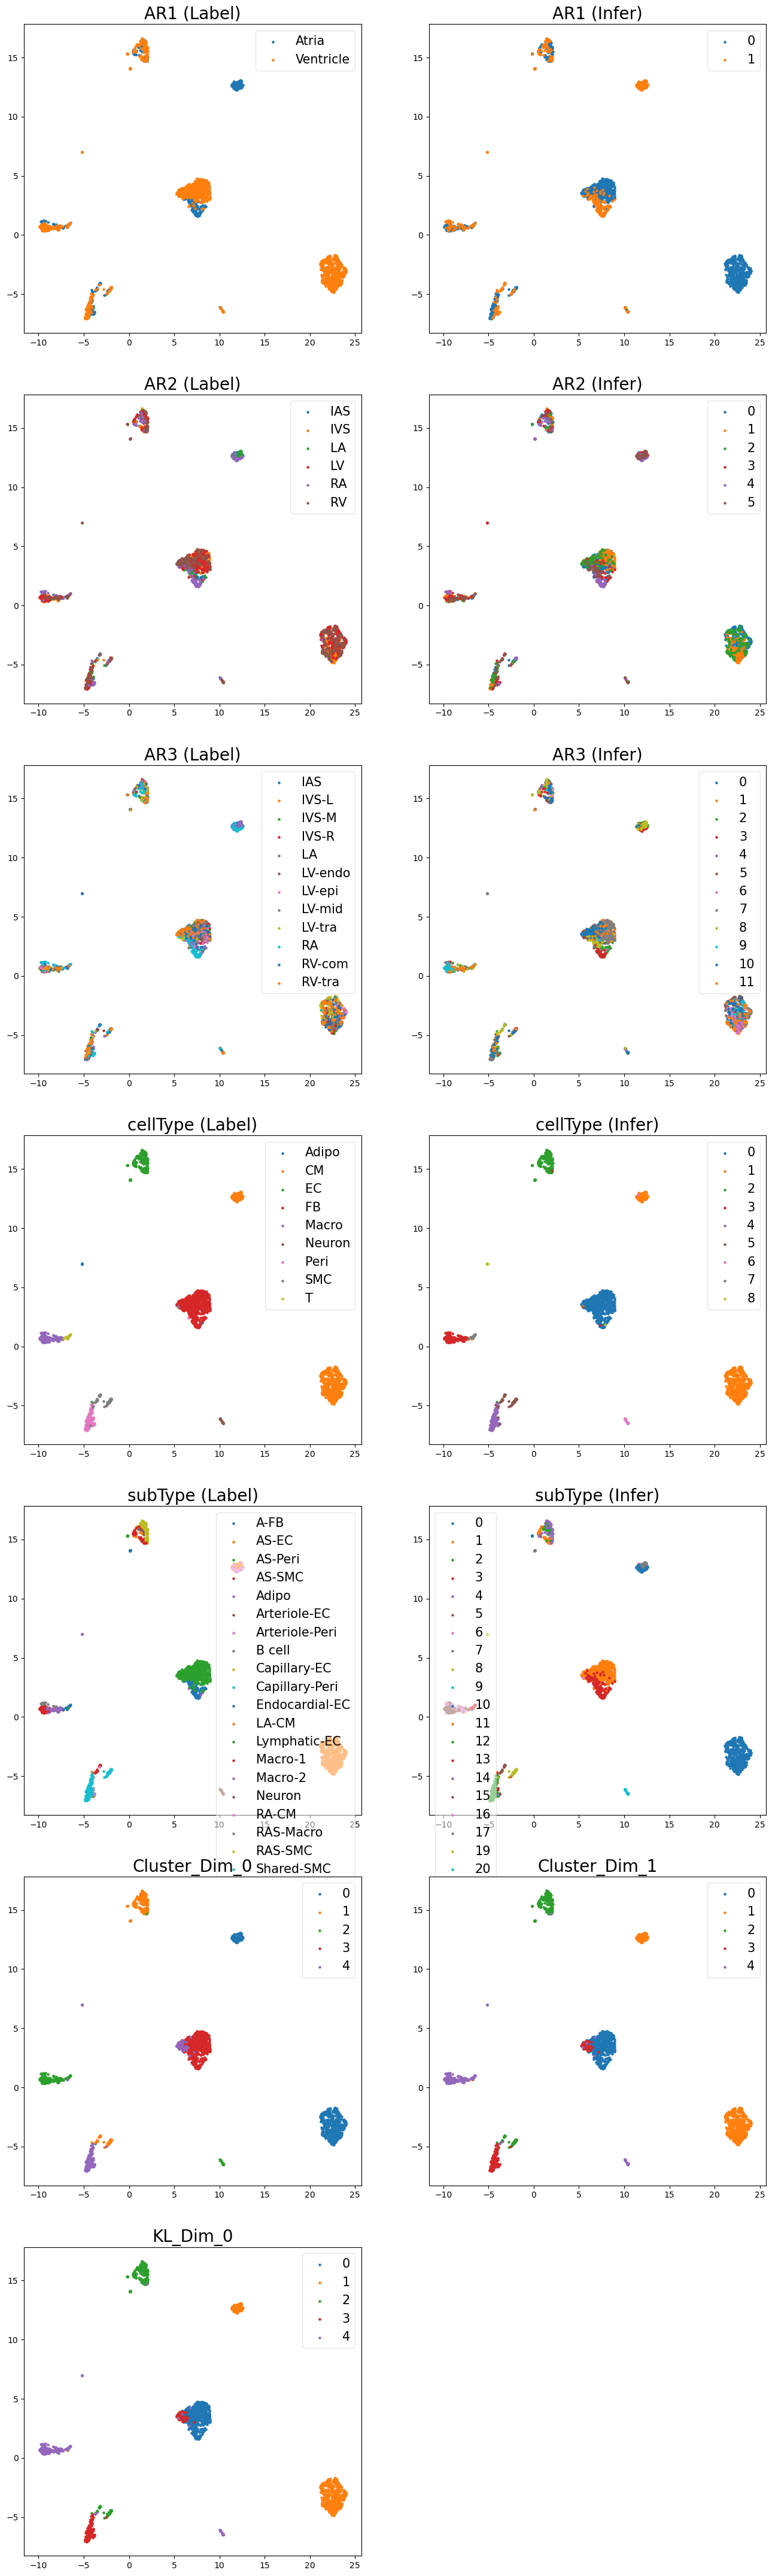

In [30]:
fig = draw_scatter_with_discrete_labels(u, labels_disc)
fig.show()

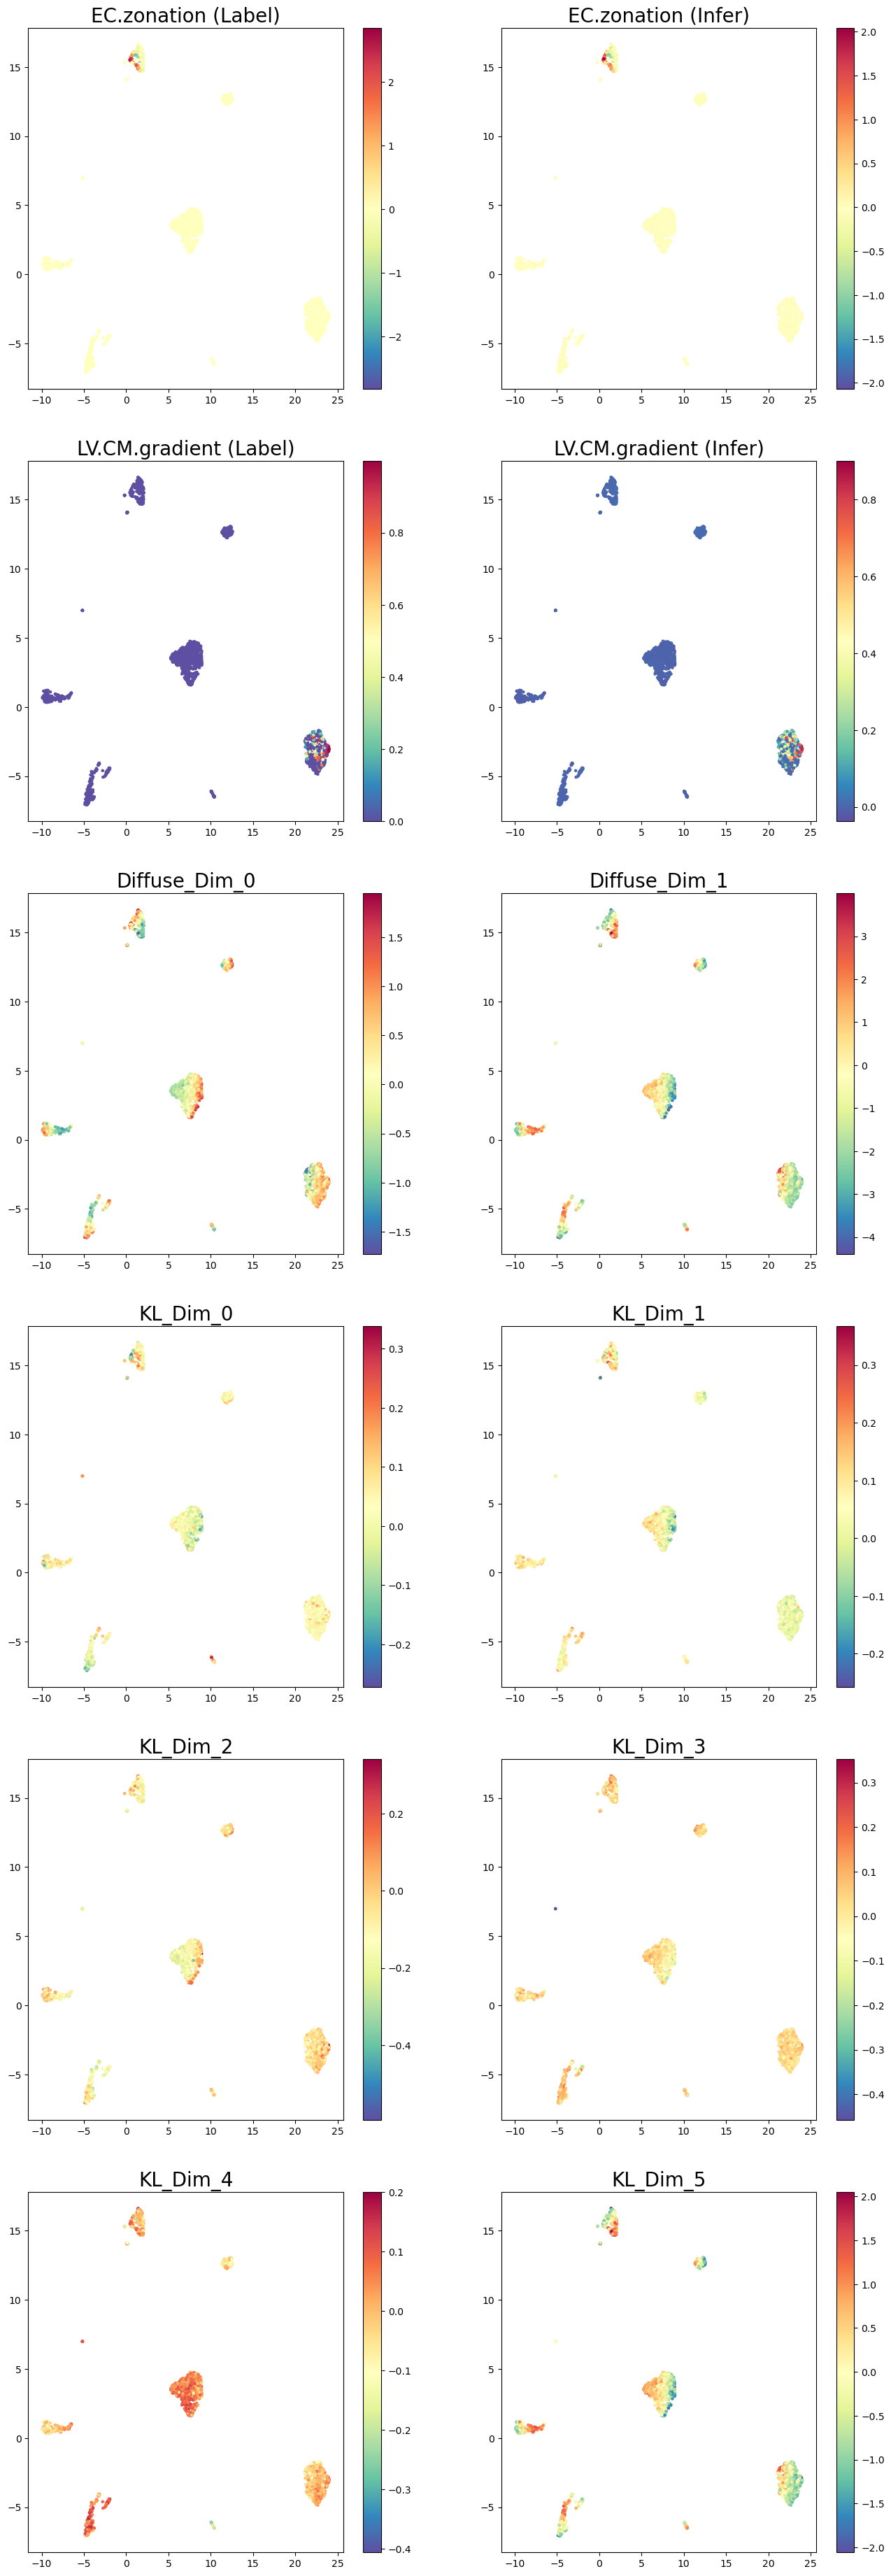

In [31]:
fig = draw_scatter_with_continuous_labels(u, labels_cont)
fig.show()

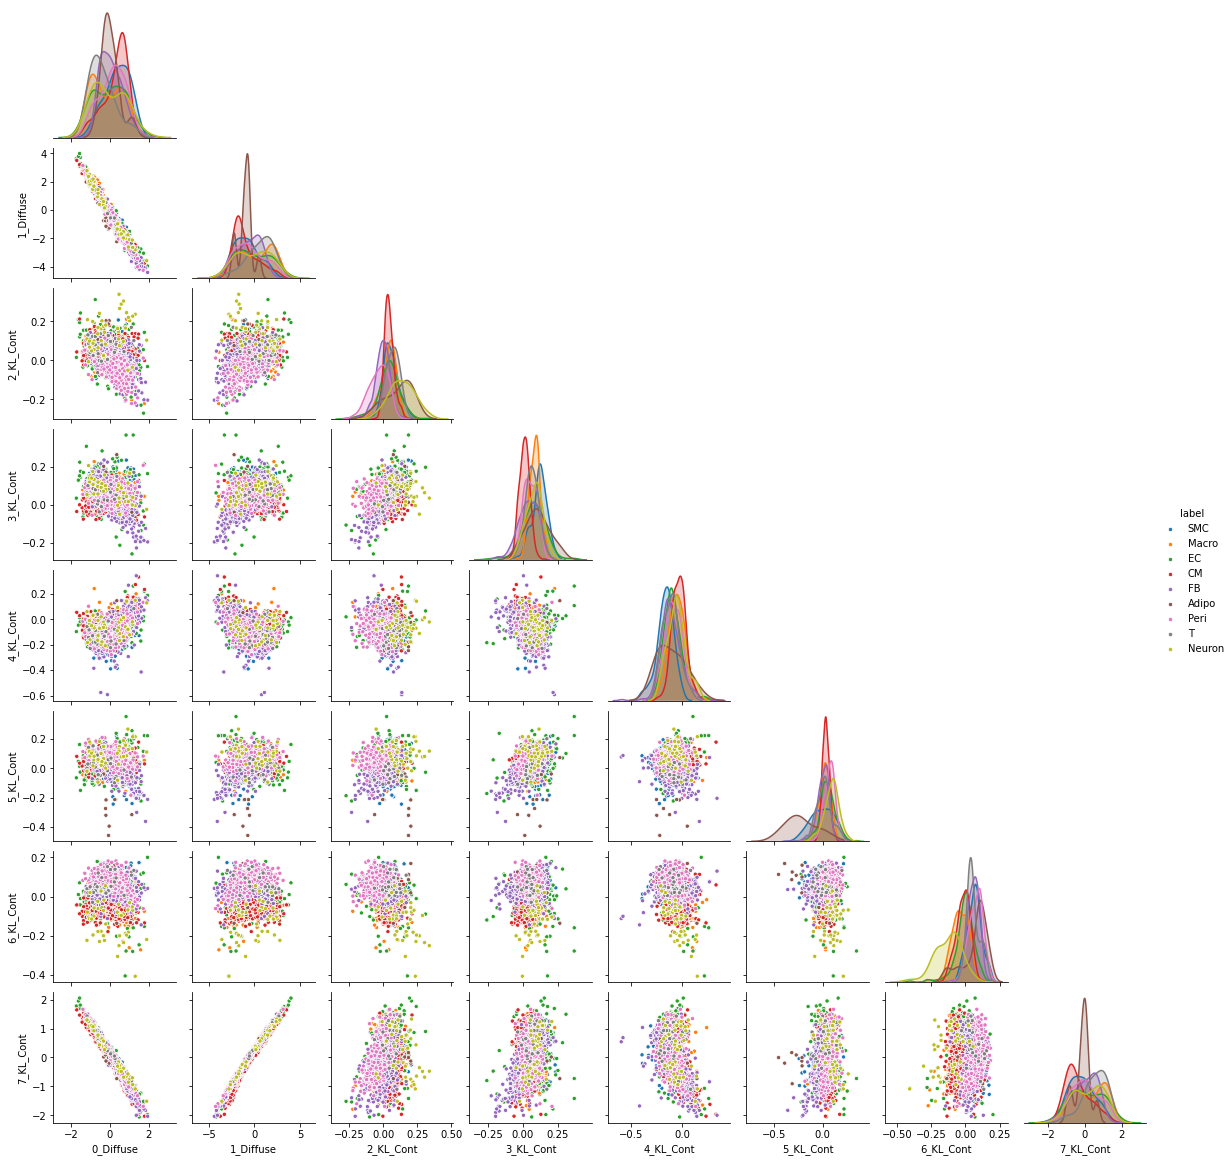

In [32]:
max_draw_cont = 8
label_name = 'cellType'
label_pos = [idx for idx,name in enumerate(label_names) if name==label_name][0]
group_index = group_indexes_reverse[label_name]
embeddings = np.array(latent_dist['cont'][0].cpu())
embeddings = embeddings[:,0:min(max_draw_cont, len(embeddings))]
embeddings = pd.DataFrame(embeddings)
embeddings.columns = latent_name_cont[0:min(max_draw_cont, len(embeddings))]
embeddings['label'] = [group_index[int(i)] for i in data[1][:,label_pos].int()]

fig = sns.pairplot(embeddings,hue="label", plot_kws={'size':1}, height = 2, aspect = 1, corner=True)
plt.show()

In [33]:
latent_u  = umap.UMAP().fit_transform(torch.cat(latent_dist['cont'][0].cpu(), latent_dist['disc'])

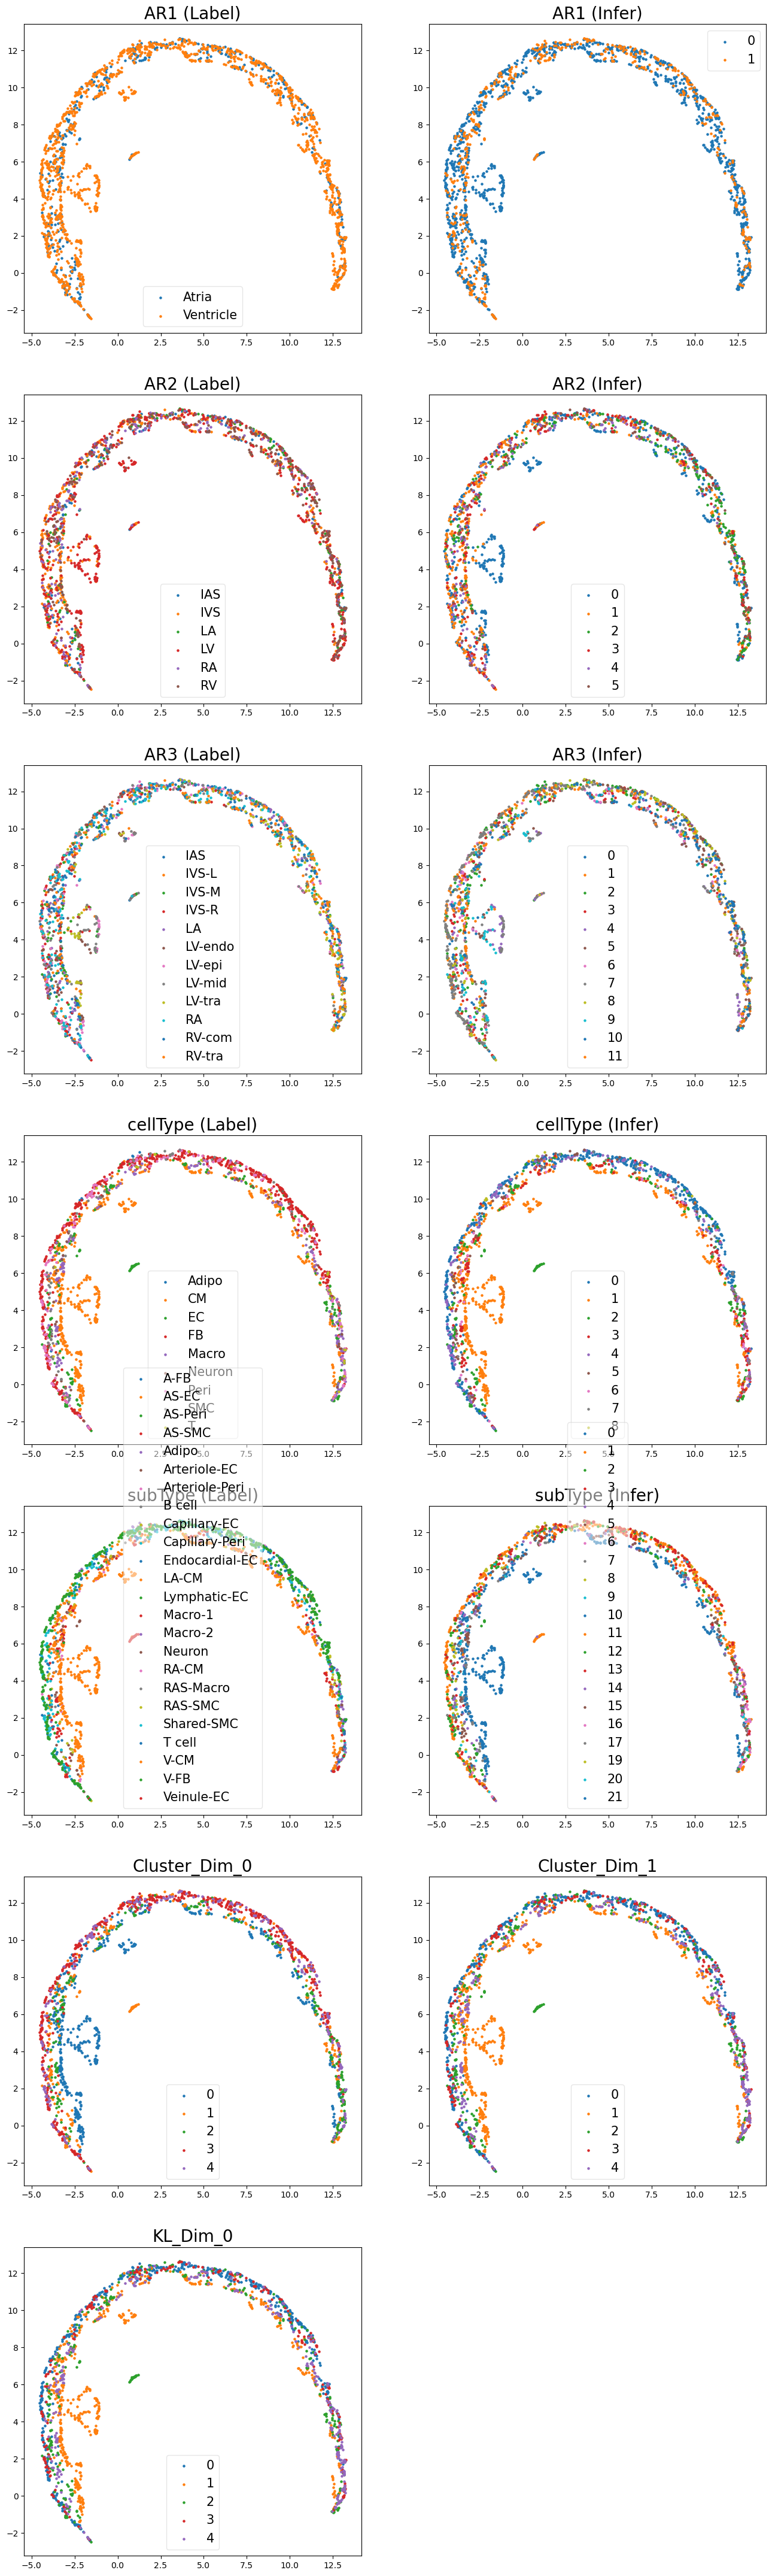

In [34]:
fig = draw_scatter_with_discrete_labels(latent_u, labels_disc)
fig.show()

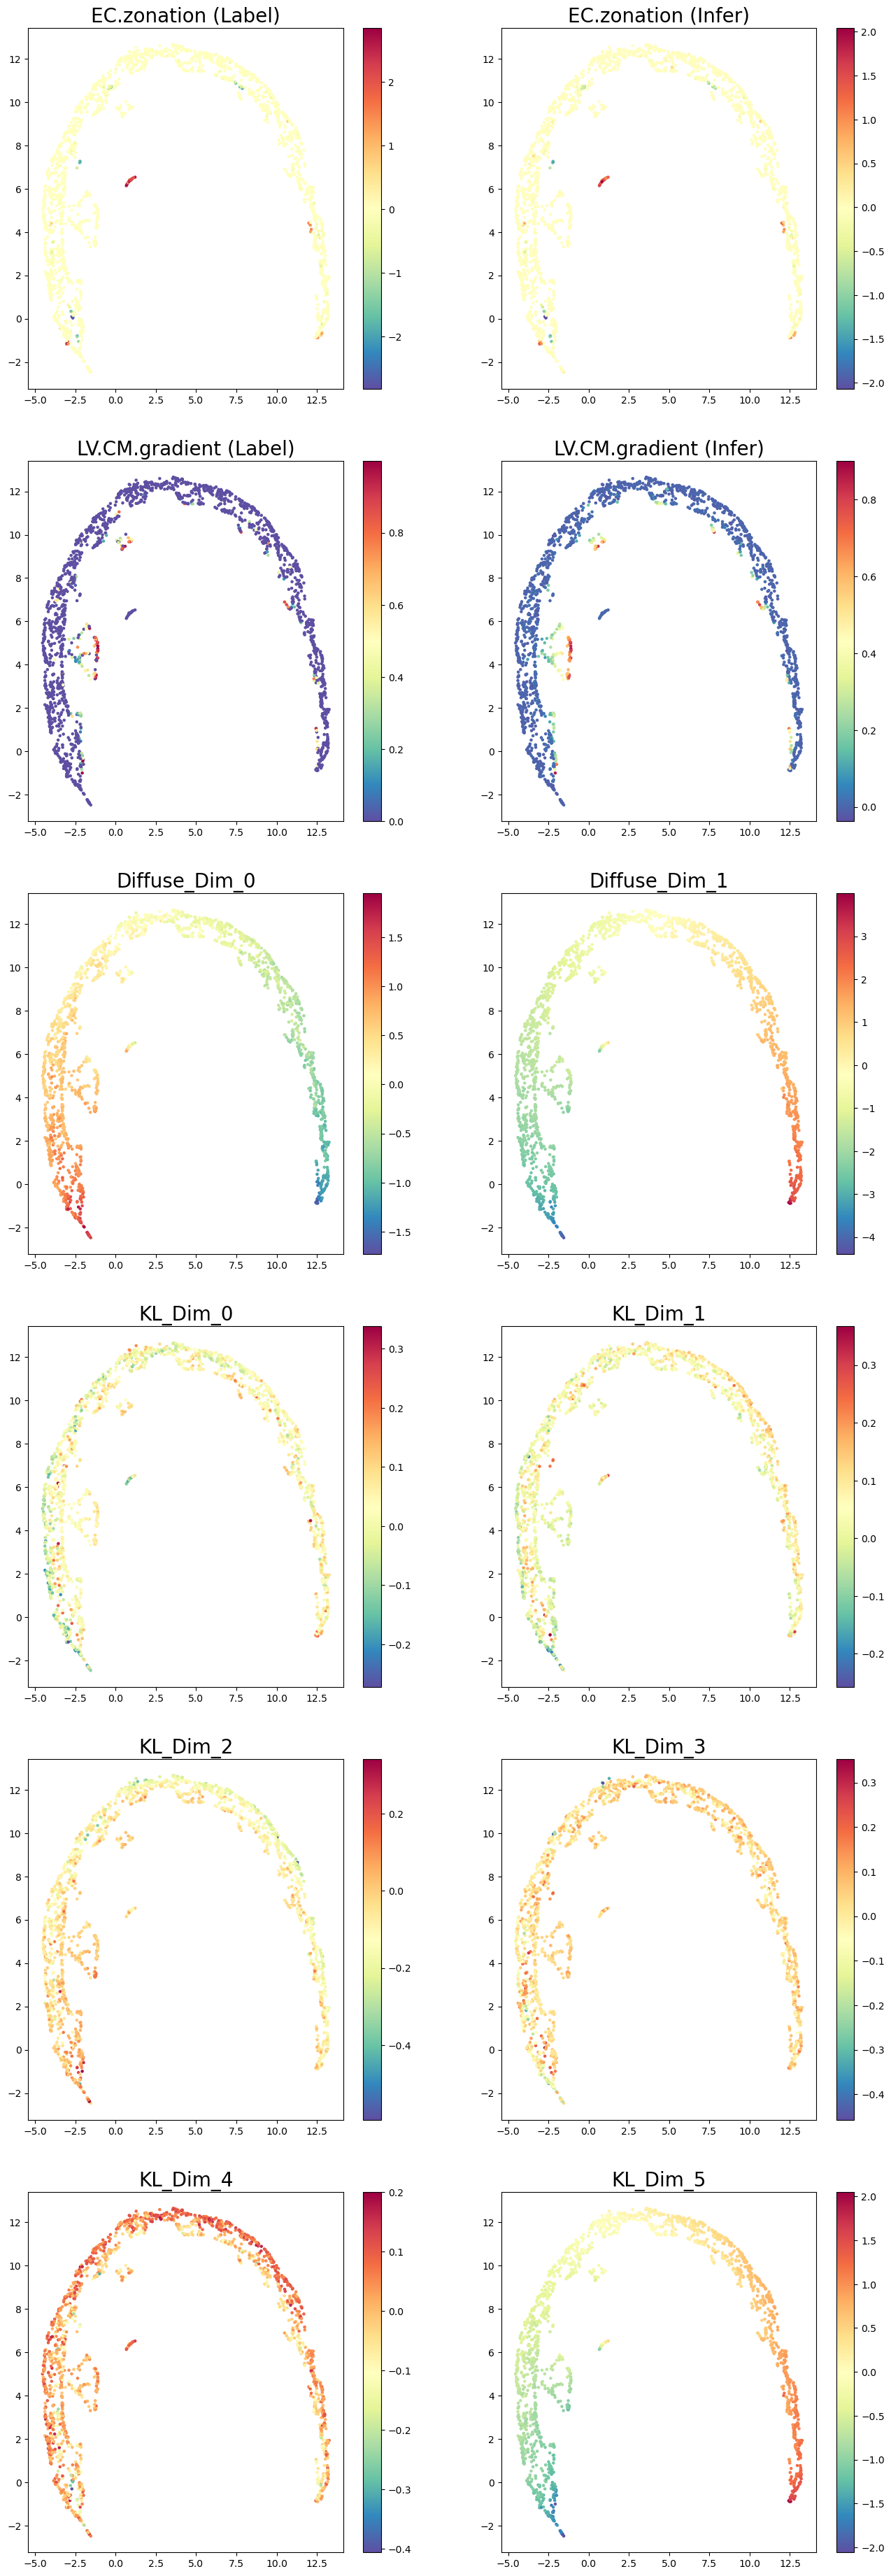

In [35]:
fig = draw_scatter_with_continuous_labels(latent_u, labels_cont)
fig.show()